In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

In [79]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
# torch.manual_seed(777)
# if device =='cuda':
#     torch.cuda.manual_seed_all(777)

cuda


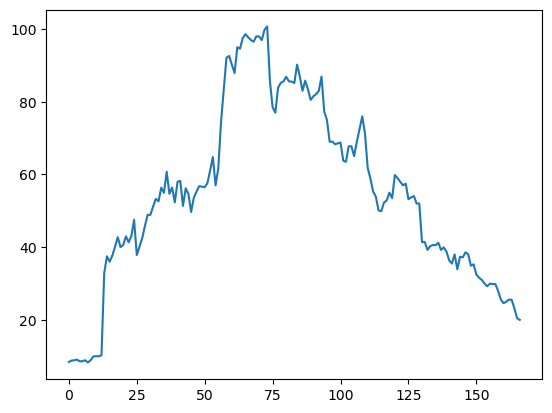

In [80]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os

path = 'C://Users/gkdud/PycharmProjects/pythonprojects/NH/data/stock_prices/'
flist = glob.glob(os.path.join(path, '*.csv'))
df = pd.read_csv(flist[2])[['close']].values.astype('float32')
df = pd.read_csv('./data/AAMC 과거 데이터.csv')[['종가']].values.astype('float32')

plt.plot(df)
plt.show()

In [81]:
import torch
 
def create_dataset2(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+lookback:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X).squeeze(), torch.tensor(y).squeeze(-1)

In [82]:
lookback = 7
# train-test split for time series
train_size = int(len(df) * 0.67)
test_size = len(df) - train_size
train, test = df[:train_size], df[train_size:]
X_train, y_train = create_dataset2(train, lookback=lookback)
X_test, y_test = create_dataset2(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([104, 7]) torch.Size([104, 1])
torch.Size([49, 7]) torch.Size([49, 1])


In [83]:
import torch.nn as nn
 
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(7, 50)
        self.linear2 = nn.Linear(50, 2)
        
        self.saved_log_probs = []
        self.rewards = []
        
    def forward(self, x):
        x = nn.ReLU()(self.linear1(x))
        x = self.linear2(x)
        return x

In [91]:
import random
from torch.distributions.normal import Normal
from itertools import count
# Notation
# state: 이전 일주일간의 데이터
# action: 다음 하루의 예측값(모델의 출력)
# y_ref: real value
class Agent:
    def __init__(self, data, model, optimizer, win_size=7):
        self.data = data
        self.model = model
        self.optimizer = optimizer
        self.win_size = win_size
        self.steps = 0
        self.EPS_END = 0.01
        self.EPS_START = 0.9
        self.EPS_DECAY = 200
        self.gamma = 0.8
        self.eps = np.finfo(np.float32).eps.item()
    
    def getState(self, t): # get state in time t (data[time : time+win_size])
        s = t - self.win_size + 1
        return self.data[s:t+1] if s >= 0 else -s*[self.data[0]] + self.data[0:t+1]
    
    # def select_action(self, state): # 임시로 설정
    #     with torch.no_grad():
    #         return self.model(torch.tensor([state], dtype=torch.float)).argmax(1)
        
    def select_action(self, state):
        state = torch.tensor(state).float().unsqueeze(0)
        logits = self.model(state)
        m = Normal(loc=logits[:,0], scale=F.softplus(logits[:,1]))
        action = torch.clamp(m.sample(), state[-1][-1].item()-100.0, state[-1][-1].item()+100.0)
        self.model.saved_log_probs.append(m.log_prob(action))
        return action.item()
    '''
    # def select_action(self, state): # non-continuous일때
    #     sample = random.random()
    #     eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * math.exp(-1. * self.steps / self.EPS_DECAY)
    #     self.steps += 1
    #     if sample > eps_threshold:
    #         with torch.no_grad():
    #             return self.model(torch.tensor([state], dtype=torch.float)).argmax(1)
    #     else:
    #         return torch.tensor([random.randrange(2)], dtype=torch.long)
        
    # def select_action(self, state): # continuous일때
    #     state = torch.from_numpy(state).float().unsqueeze(0)
    #     logits = self.model(state)
    #     m = Normal(loc=logits[:,0], scale=F.softplus(logits[:,1]))
    #     action = torch.clamp(m.sample(), -1.0, 1.0)
    #     self.model.saved_log_probs.append(m.log_prob(action))
    #     return action.item()
    '''
    def getReward(self, state, action): # calc reward where prediction is action
        # define as relative change (y - y_ref) / y_ref
        return (action - state[-1]) / state[-1]
    
    def finish_episode(self):
        R = 0
        policy_loss = []
        returns = []
        for r in self.model.rewards[::-1]:
            R = r + self.gamma * R
            returns.append(R)
        returns = torch.tensor(returns[::-1])
        returns = (returns - returns.mean()) / (returns.std() + self.eps)
        for log_prob, R in zip(self.model.saved_log_probs, returns):
            policy_loss.append(-log_prob * R)
        self.optimizer.zero_grad()
        policy_loss = torch.cat(policy_loss).mean()
        policy_loss.backward()
        self.optimizer.step()
        del self.model.rewards[:]
        del self.model.saved_log_probs[:]
    
    def main(self, ):
        running_reward = 10
        rewards = []
        for i_episode in count(1):
            state, ep_reward = self.getState(0), 0
            for t in range(int(len(self.data)*0.67)):  # Don't infinite loop while learning
                state = self.getState(0)
                action = self.select_action(state)
                reward = self.getReward(state, action)
                state[-1] = action
                self.model.rewards.append(reward)
                ep_reward += reward

            self.finish_episode()
            print('Episode {}\treward: {:.2f}'.format(i_episode, ep_reward))
            rewards.append(ep_reward)
            if ep_reward >= 0 or i_episode == 10000:
                print('Solved!')
                break
        return rewards

In [92]:
model = Model()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
eps = np.finfo(np.float32).eps.item()

In [93]:
agent = Agent(list(df.squeeze()), model, optimizer)
reward = agent.main()

Episode 1	reward: -99.02
Episode 2	reward: -95.89
Episode 3	reward: -95.31
Episode 4	reward: -95.54
Episode 5	reward: -95.36
Episode 6	reward: -94.82
Episode 7	reward: -94.39
Episode 8	reward: -92.98
Episode 9	reward: -92.26
Episode 10	reward: -90.67
Episode 11	reward: -90.48
Episode 12	reward: -88.62
Episode 13	reward: -86.79
Episode 14	reward: -85.62
Episode 15	reward: -84.16
Episode 16	reward: -84.12
Episode 17	reward: -82.86
Episode 18	reward: -80.65
Episode 19	reward: -79.36
Episode 20	reward: -77.47
Episode 21	reward: -75.89
Episode 22	reward: -74.11
Episode 23	reward: -72.60
Episode 24	reward: -70.29
Episode 25	reward: -69.43
Episode 26	reward: -67.24
Episode 27	reward: -65.99
Episode 28	reward: -64.13
Episode 29	reward: -63.00
Episode 30	reward: -61.86
Episode 31	reward: -60.05
Episode 32	reward: -58.48
Episode 33	reward: -56.85
Episode 34	reward: -54.58
Episode 35	reward: -53.50
Episode 36	reward: -51.45
Episode 37	reward: -49.47
Episode 38	reward: -49.32
Episode 39	reward: -4

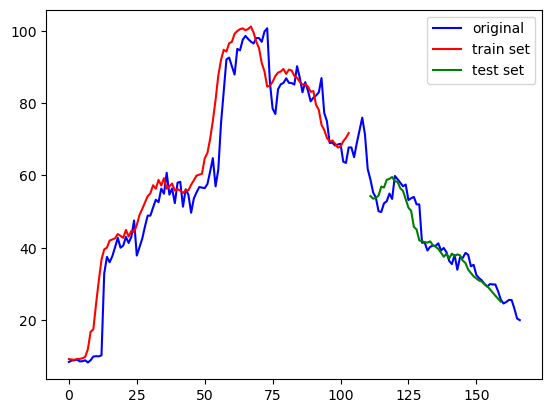

In [96]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(df) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1]
    train_plot[lookback:train_size] = model(X_train)[:, 0].unsqueeze(1)
    # shift test predictions for plotting
    test_plot = np.ones_like(df) * np.nan
    test_plot[train_size+lookback:len(df)] = model(X_test)[:, 0].unsqueeze(1)
# plot
plt.plot(df, c='b', label='original')
plt.plot(train_plot[7:], c='r', label='train set')
plt.plot(test_plot[7:], c='g', label='test set')
plt.legend()
plt.show()

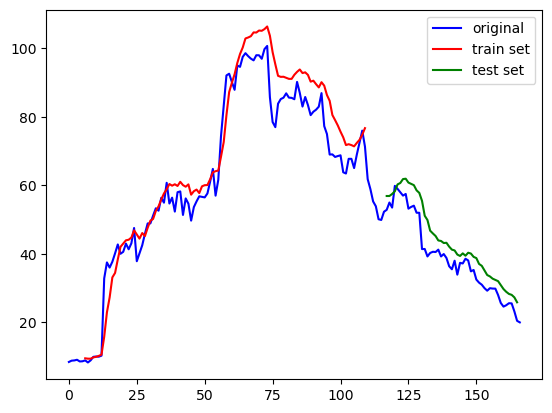